0.9221200902259601


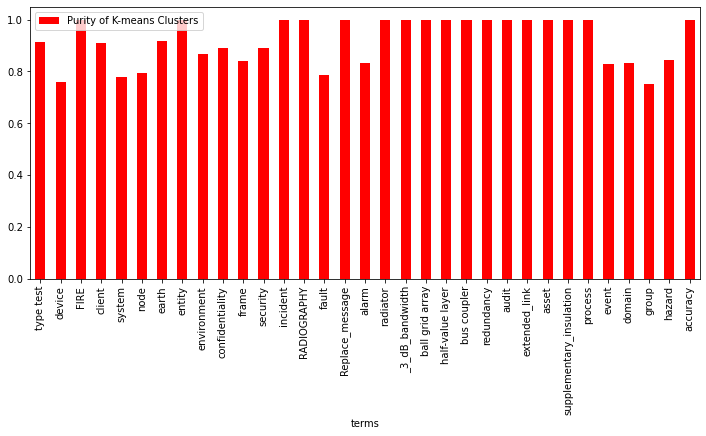

In [3]:
import pandas as pd
from string import digits
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, util, InputExample


def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 


# selecting sentences with a particular group_id
def sub_groups(df, group_id):
    df_1 = df[['grp_id1','sentence1']]
    df_2 = df[['grp_id2','sentence2']]

    df_1=df_1.loc[df['grp_id1'] == group_id]
    df_1=df_1.drop_duplicates('sentence1')
    df_1.columns=['grp_id','sentence'] 

    df_2=df_2.loc[df['grp_id2'] == group_id]
    df_2=df_2.drop_duplicates('sentence2')
    df_2.columns=['grp_id','sentence'] 

    return pd.concat([df_1,df_2]).drop_duplicates().reset_index(drop=True)


# reading tsv
df=pd.read_csv('datasets/gold_dataset2.tsv', delimiter="\t")

# selecting the use defined groups of a term
df_term_group1 = df['grp_id1'].drop_duplicates()
df_term_group2 = df['grp_id2'].drop_duplicates()
df_term_groups = list(pd.concat([df_term_group1,df_term_group2]).drop_duplicates().reset_index(drop=True))

# loading the pretrained model
model = SentenceTransformer('distilroberta-base-paraphrase-v1')

remove_digits = str.maketrans('', '', digits)


df_term = df['term'].drop_duplicates().reset_index(drop=True)
purity_df=[]
for i in df_term:
    group_names=[]   # list of groups for each term
    cluster_number=0  # no.of clusters for each term
    for j in df_term_groups:
        if i.translate(remove_digits) == j.translate(remove_digits):
            cluster_number += 1
            group_names.append(j)
    df_on_term=pd.DataFrame()
    
    # grouping all the sentences that belongs to the same term
    if group_names:
        for k in group_names:
                df_on_term=pd.concat([df_on_term,sub_groups(df, k)]).drop_duplicates().reset_index(drop=True)  
        
        # Encoding the sentence
        df_on_term['embedding'] = [model.encode(i) for i in df_on_term['sentence']]  
        kmeans = KMeans(n_clusters=cluster_number, random_state=0).fit(list(df_on_term['embedding']))  # K means clustering
        purity = purity_score(list(df_on_term['grp_id']),kmeans.labels_) # Purity calculation
        purity_df.append([i,purity])

plot_df=pd.DataFrame(purity_df, columns=['terms','Purity of K-means Clusters'])
print(np.mean(plot_df['Purity of K-means Clusters']))
fig=plot_df.plot.bar(x='terms', y='Purity of K-means Clusters',figsize=(12, 5), rot=90, color='red').get_figure()
fig.savefig("plots/clustering/purity.jpg",bbox_inches='tight')



In [21]:
print('device' in list(plot_df['terms']))

True


In [28]:
import os
rootdir = 'datasets_labeled/removed'

terms = []
for [subdir, dirs, files], [subdir1, dirs1, files1] in zip(os.walk(rootdir), os.walk('datasets/removed')):
    terms.append(str(subdir1[25:]))

print(terms)

['', 'accuracy', 'alarm', 'application_process', 'asset', 'audit', 'ball grid array', 'bus coupler', 'client', 'confidentiality', 'device', 'diversity', 'domain', 'double_insulation', 'earth', 'entity', 'environment', 'event', 'extended_link', 'fault', 'FIRE', 'frame', 'group', 'half-value layer', 'hazard', 'incident', 'integrity', 'node', 'process', 'radiator', 'RADIOGRAPHY', 'redundancy', 'Replace_error', 'Replace_message', 'Replace_role', 'resource', 'security', 'supplementary_insulation', 'system', 'type test', '_3_dB_bandwidth']


set()


In [48]:
pd.concat([plot_df['terms'],pd.DataFrame(terms[1:])]).drop_duplicates(keep=False)

,0
2,application_process
10,diversity
12,double_insulation
25,integrity
31,Replace_error
33,Replace_role
34,resource
